# Overfitting Or When Your Model Tries Too Hard to Please

In [68]:
import random
import json
import gzip
from itertools import product
import subprocess
import os

import numpy as np

# DataViz
import matplotlib.pyplot as plt

# SKLearn Tools
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# ML Models
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

# Utils
from tqdm.notebook import tqdm
import pyperclip

In [2]:
# matplotlib Color Setup
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Dracula Color Palette
COL_Background = '#272934'
COL_Selection = '#44475a'
COL_Foreground = '#f8f8f2'
COL_Comment = '#6272a4'
COL_Cyan = '#8be9fd'
COL_Green = '#50fa7b'
COL_Orange = '#ffb86c'
COL_Pink = '#ff79c6'
COL_Purple = '#bd93f9'
COL_Red = '#ff5555'
COL_Yellow = '#f1fa8c'

sequential_cmap = LinearSegmentedColormap.from_list(
    'custom_sequential', [COL_Comment, COL_Purple]
)

diverging_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging', [COL_Cyan, COL_Comment, COL_Purple]
)

categorical_cmap = ListedColormap([COL_Cyan, COL_Green, COL_Orange, COL_Pink, COL_Purple, COL_Red, COL_Yellow])

plt.rcParams.update({
    'figure.facecolor': COL_Background,
    'axes.facecolor': COL_Background,
    'axes.edgecolor': COL_Background,
    'axes.labelcolor': COL_Comment,
    'text.color': COL_Comment,
    'xtick.color': COL_Comment,
    'ytick.color': COL_Comment,
    'grid.color': COL_Selection
})

In [3]:
SEED = 2

## 1. A Gentle Start: Fitting Curves with Polynomials

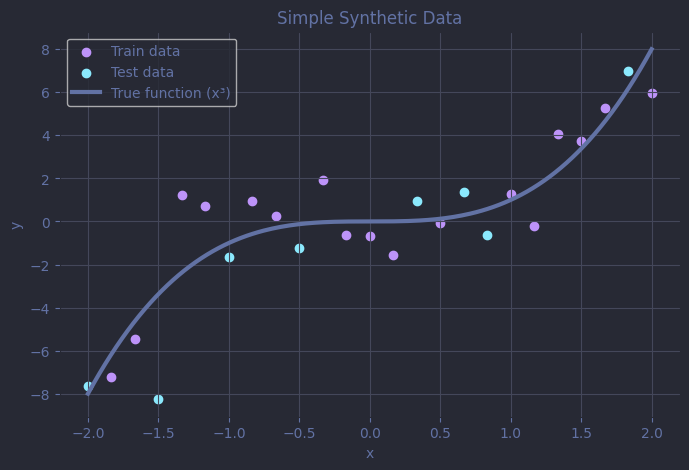

In [60]:
rng = np.random.default_rng(SEED)

X = np.linspace(-2, 2, 25)
y = (X ** 3) + rng.normal(0, 2, size=X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

X_plot = np.linspace(-2, 2, 200)
y_plot_true = X_plot ** 3

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
X_plot = X_plot.reshape(-1, 1)

# Visualisation
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, color=COL_Purple, label='Train data')
plt.scatter(X_test, y_test, color=COL_Cyan, label='Test data')
plt.plot(X_plot, y_plot_true, color=COL_Comment, linewidth=3, label='True function (x³)')
plt.title("Simple Synthetic Data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig('simple_synthetic_data.png')
plt.show()

In [72]:
degrees = list(range(1, 17))
results = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    X_plot_poly = poly.transform(X_plot)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_plot_pred = model.predict(X_plot_poly)

    results.append({
        "degree": degree,
        "train_mae": mean_absolute_error(y_train, y_train_pred),
        "test_mae": mean_absolute_error(y_test, y_test_pred),
        "y_plot_pred": y_plot_pred
    })

In [74]:
# output data for interactive vizualisation
variables = {
    "degrees": [r["degree"] for r in results],
    "train_maes": [round(r["train_mae"], 2) for r in results],
    "test_maes": [round(r["test_mae"], 2) for r in results],
    "y_preds": [np.round(r["y_plot_pred"], 2).tolist() for r in results],
    "x_plot": np.round(X_plot.flatten(), 2).tolist(),
    "y_true": np.round(y_plot_true, 2).tolist(),
    "X_train": np.round(X_train.flatten(), 2).tolist(),
    "y_train": np.round(y_train, 2).tolist(),
    "X_test": np.round(X_test.flatten(), 2).tolist(),
    "y_test": np.round(y_test, 2).tolist(),
}

clipboard_string = ''
for v, data in variables.items():
    clipboard_string += f'const {v} = {json.dumps(data)};\n'
pyperclip.copy(clipboard_string)
print('Clipboard filled.')

Clipboard filled.


## 2. From Curve Fitting to Income Prediction

### Simulating Real-World Data (Sort Of)

In [77]:
def income(age, rng=None):
    if age < 12:
        income = 0
    elif age < 30:
        a = 55000 / ((30 - 12) ** 3) 
        income = a * (age - 12) ** 3
    elif age < 60:
        income = 55000 + 350 * (age - 30)
    else:
        income = 65500 - (age - 60) * (15500 / 30)

    # noise
    center = 55
    half_width = 45
    k = 1 / (half_width ** 2)
    noise_factor = max(0, -k * (age - center) ** 2 + 1)

    income += rng.normal(0, noise_factor * 20000) if rng else 0
    return max(0, income)

def generate_data(nb_rows, linear_sampling=False):
    rng = np.random.default_rng(SEED)

    # Age Feature
    if linear_sampling:
        age_feature = np.linspace(0, 90, nb_rows)
    
    else: # Realistic sampling (less children and elderly)
        normal_dist_ages = rng.normal(loc=40, scale=18, size=nb_rows*2)
        age_feature = normal_dist_ages[(normal_dist_ages >= 0) & (normal_dist_ages <= 90)][:nb_rows]
        if len(age_feature) < nb_rows: print('Unlucky Seed!')

    # Target variable : income
    y = np.array([income(x, rng=rng) for x in age_feature])
    # dist_from_peak
    dist_from_peak = np.abs(60 - age_feature)
    # Random features
    uniform_noise = rng.uniform(0, 100, size=nb_rows)
    normal_noise = rng.normal(50, 20, size=nb_rows)
    random_cat = rng.integers(0, 9, size=nb_rows)

    X = np.column_stack([
        age_feature,
        dist_from_peak,
        uniform_noise,
        normal_noise,
        random_cat
    ])

    return X, y
    
X_train, y_train = generate_data(1000)
X_test, _ = generate_data(200, linear_sampling=True)
y_test = [income(age, rng=None) for age in X_test[:, 0]]

In [78]:
# Visualisation: Create a smoothed interquartile band
bin_edges = np.linspace(0, 90, 90)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_q25 = []
bin_q75 = []

for start, end in zip(bin_edges[:-1], bin_edges[1:]):
    mask = (X_train[:, 0] >= start) & (X_train[:, 0] < end)
    incomes_in_bin = y_train[mask]

    if len(incomes_in_bin) > 0:
        q25 = np.percentile(incomes_in_bin, 25)
        q75 = np.percentile(incomes_in_bin, 75)
        bin_q25.append(q25)
        bin_q75.append(q75)
    else:
        bin_q25.append(np.nan)
        bin_q75.append(np.nan)

def moving_avg(arr, size):
    arr = np.nan_to_num(arr, nan=np.nanmean(arr))
    padded = np.pad(arr, size//2, mode='edge')
    return np.convolve(padded, np.ones(size)/size, mode='valid')

bin_q25_smooth = moving_avg(bin_q25, 7)
bin_q75_smooth = moving_avg(bin_q75, 7)

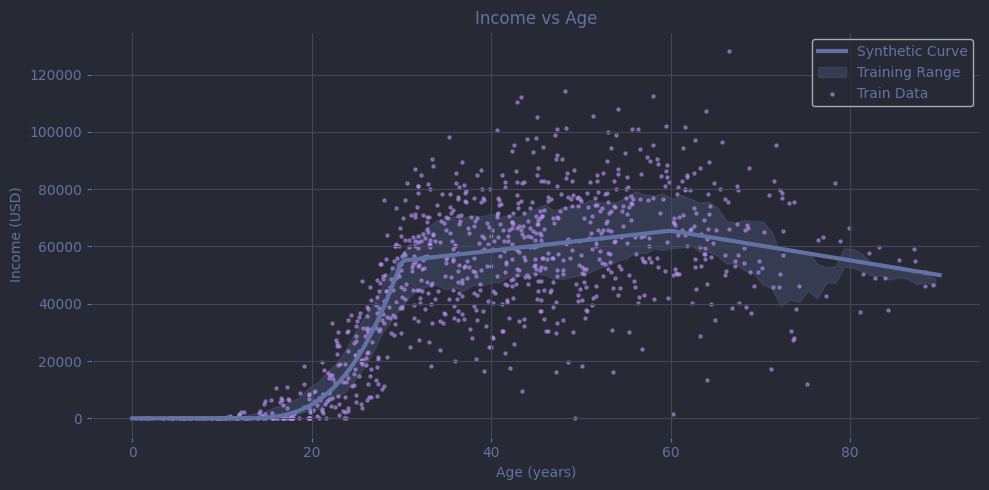

In [79]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(X_test[:, 0], y_test, label="Synthetic Curve", color=COL_Comment, linewidth=3)
plt.fill_between(bin_centers, bin_q25_smooth, bin_q75_smooth, color=COL_Comment, alpha=0.25, label="Training Range")
plt.scatter(X_train[:, 0], y_train, label="Train Data", color=COL_Purple, s=5, alpha=0.5)
plt.xlabel("Age (years)")
plt.ylabel("Income (USD)")
plt.title("Income vs Age")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('better_synthetic_data.png')
plt.show()

### One Dataset, Three Very Different Fits

In [80]:
common_params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'min_sum_hessian_in_leaf': 0,
    'min_data_in_leaf': 1,
    'feature_pre_filter': False,
    'verbosity': -1,
    'seed': SEED,
    'deterministic' : True
}

train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=[4])

In [81]:
# Overfitting Model
overfit_params = {
    'num_leaves': 128,
    'num_iterations': 1000,
}
overfit_model = lgb.train(common_params | overfit_params, train_dataset)

y_preds_overfit = overfit_model.predict(X_test)
mae_overfit = mean_absolute_error(y_test, y_preds_overfit)

In [82]:
# Underfitting Model
underfit_params = {
    'num_leaves': 2,
    'num_iterations': 50,
}
underfit_model = lgb.train(common_params | underfit_params, train_dataset)

y_preds_underfit = underfit_model.predict(X_test)
mae_underfit = mean_absolute_error(y_test, y_preds_underfit)

In [83]:
# Regularized Model
param_grid = {
    'num_leaves': [2, 3, 4, 6, 8],
    'min_data_in_leaf': [1, 2, 3, 4, 5, 8, 10, 20],
    'lambda_l2': [0, 5, 10, 15, 20, 25, 30, 40, 50],
    'colsample_bynode': [1, 0.8, 0.6, 0.4, 0.2],
}

keys = list(param_grid)
values = [param_grid[k] for k in keys]
param_combinations = [dict(zip(keys, v)) for v in product(*values)]
random.shuffle(param_combinations)

best_score = float('inf')
best_params = None

for combination in tqdm(param_combinations):
    model = lgb.train(
        common_params | combination | {'num_iterations': 10000, 'early_stopping_rounds': 20},
        train_dataset,
        valid_sets=lgb.Dataset(X_test, label=y_test, categorical_feature=[4])
    )
    mae = mean_absolute_error(y_test, model.predict(X_test))
    
    if mae < best_score:
        best_score = mae
        best_params = combination | {'num_iterations' : model.best_iteration}

regularized_model = lgb.train(best_params, train_dataset)

print('Trained Regularized Model')
for name, param in best_params.items():
    print(f'{name} : {param}')

y_preds_regularized = regularized_model.predict(X_test)
mae_regularized = mean_absolute_error(y_test, y_preds_regularized)

  0%|          | 0/1800 [00:00<?, ?it/s]

Trained Regularized Model
num_leaves : 2
min_data_in_leaf : 2
lambda_l2 : 15
colsample_bynode : 0.8
num_iterations : 188


### Overfit, Underfit, Just-Right: The Visuals

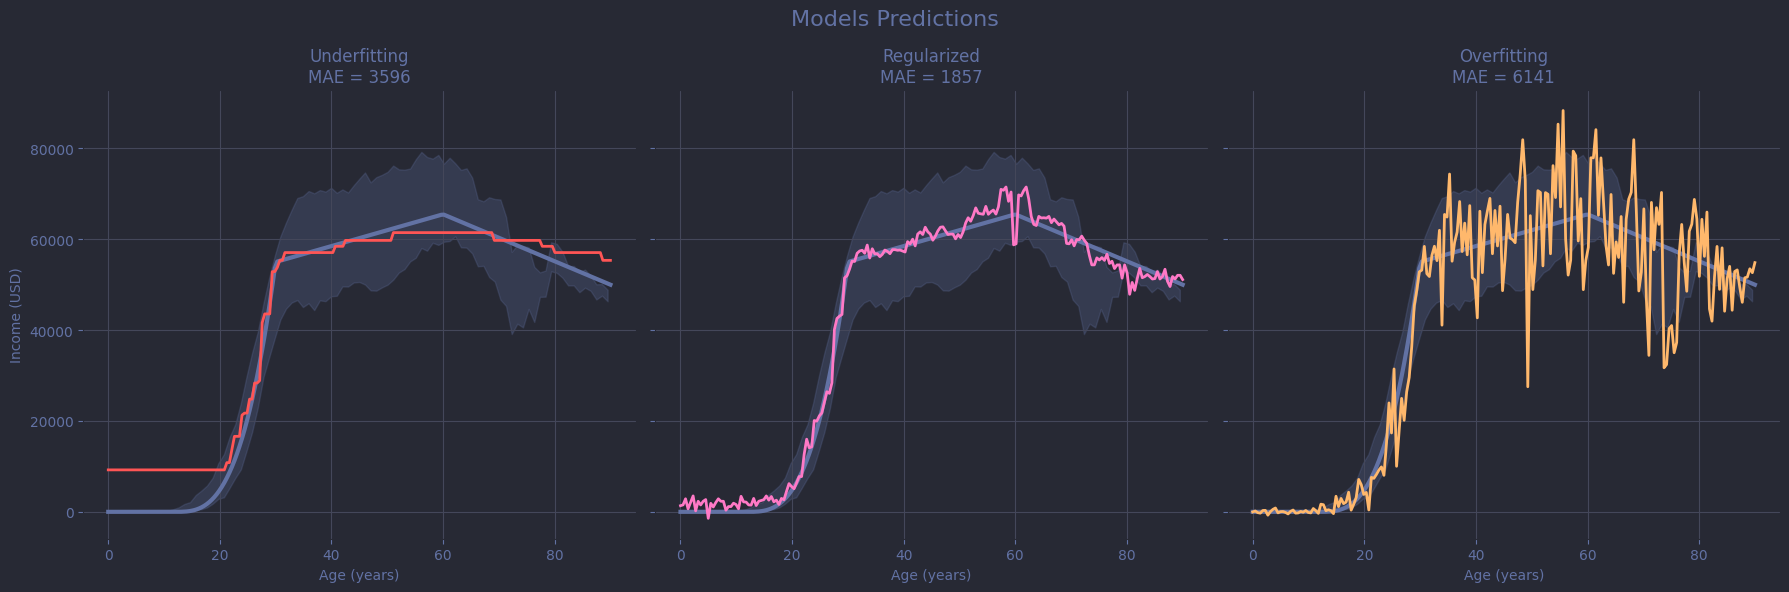

In [84]:
# Visualization
titles = ["Underfitting", "Regularized", "Overfitting"]
colors = [COL_Red, COL_Pink, COL_Orange]
predictions = [
    y_preds_underfit,
    y_preds_regularized,
    y_preds_overfit
]
maes = [mae_underfit, mae_regularized, mae_overfit]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, title, prediction, color, mae in zip(axes, titles, predictions, colors, maes):
    ax.plot(X_test[:, 0], y_test, label="Synthetic Curve", color=COL_Comment, linewidth=3)
    ax.fill_between(bin_centers, bin_q25_smooth, bin_q75_smooth, color=COL_Comment, alpha=0.25)
    ax.plot(X_test[:, 0], prediction, label="Model Prediction", color=color, linewidth=2)
    ax.set_title(f"{title}\nMAE = {mae:.0f}")
    ax.set_xlabel("Age (years)")
    ax.grid(True)

axes[0].set_ylabel("Income (USD)")

fig.suptitle("Models Predictions", fontsize=16)
plt.tight_layout()
plt.savefig('lgbm_fit_compared.png')
plt.show()

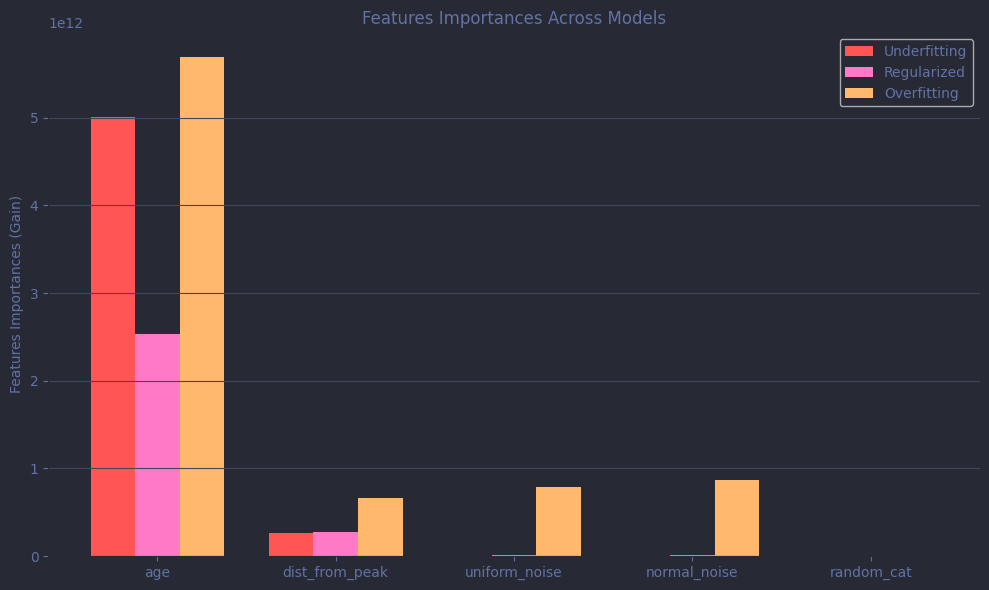

In [85]:
# Feature Importance Visualization
titles = ["Underfitting", "Regularized", "Overfitting"]
colors = [COL_Red, COL_Pink, COL_Orange]
models = [underfit_model, regularized_model, overfit_model]

feature_names = ["age", "dist_from_peak", "uniform_noise", "normal_noise", "random_cat"]
bar_width = 0.25
x = np.arange(len(feature_names))

plt.figure(figsize=(10, 6))

for i, (title, model, color) in enumerate(zip(titles, models, colors)):
    importances = model.feature_importance(importance_type='gain')
    plt.bar(x + i * bar_width, importances, width=bar_width, label=title, color=color)

plt.xticks(x + bar_width, feature_names)
plt.ylabel("Features Importances (Gain)")
plt.title("Features Importances Across Models")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('feature_importance_comparison.png')
plt.show()

## Interactive plot

In [94]:
param_grid = {
    'num_leaves': [2, 3, 4, 6, 8, 16, 32, 64, 128],
    'min_data_in_leaf': [1, 2, 4, 8, 16, 32, 64],
    'lambda_l2': [0, 5, 10, 15, 20, 40, 60],
    'colsample_bynode': [1, 0.8, 0.6, 0.4, 0.2],
    'num_iterations': [25, 50, 100, 150, 200, 500, 1000],
    'learning_rate': [0.5, 0.25, 0.1, 0.075, 0.05],
}

keys = list(param_grid)
values = [param_grid[k] for k in keys]
param_combinations = [dict(zip(keys, v)) for v in product(*values)]
random.shuffle(param_combinations)

try:
    with gzip.open("predictions.json.gz", "rt", encoding="utf-8") as f:
        predictions = json.load(f)
except FileNotFoundError:
    predictions = {"keys": [], "values": [], "maes": []}

done_keys = set(predictions["keys"])

for combination in tqdm(param_combinations):
    key = "_".join(str(x) for x in combination.values())
    if key in done_keys:
        continue
    params = common_params | combination

    model = lgb.train(params, train_dataset)
    preds = model.predict(X_test)
    mae = round(mean_absolute_error(y_test, preds), 3)
    scaled_preds = (preds / 100).round().tolist()

    predictions["keys"].append(key)
    predictions["maes"].append(mae)
    predictions["values"].append(scaled_preds)

    if len(predictions["keys"]) % 1000 == 0:
        with gzip.open("predictions.json.gz", "wt", encoding="utf-8") as f:
            json.dump(predictions, f)

with gzip.open("predictions.json.gz", "wt", encoding="utf-8") as f:
    json.dump(predictions, f)

  0%|          | 0/77175 [00:00<?, ?it/s]

In [95]:
with gzip.open("predictions.json.gz", 'rt', encoding='utf-8') as f:
    data = json.load(f)

results = sorted(zip(data["maes"], data["keys"]))

chosen_key = '3_2_15_0.6_50_0.1'

mae = next(mae for mae, key in results if str(key) == chosen_key)
nb_better_combi = next(i for i, (m, _) in enumerate(results) if m >= mae)

print(f'Chosen Key : {chosen_key} - MAE: {mae}, Nb Better Combinations : {nb_better_combi}')

for (mae, key) in random.sample(results[:100], 10):
    print(f"MAE: {mae} - Params: {key}")

Chosen Key : 3_2_15_0.6_50_0.1 - MAE: 1705.606, Nb Better Combinations : 525
MAE: 1644.341 - Params: 2_64_40_1_150_0.1
MAE: 1641.317 - Params: 2_1_20_1_100_0.1
MAE: 1646.061 - Params: 2_64_40_0.6_200_0.075
MAE: 1642.023 - Params: 2_8_60_1_150_0.1
MAE: 1642.075 - Params: 2_64_10_1_150_0.075
MAE: 1642.023 - Params: 2_4_60_1_150_0.1
MAE: 1634.212 - Params: 2_64_15_0.6_200_0.075
MAE: 1641.628 - Params: 2_1_40_1_200_0.075
MAE: 1641.317 - Params: 2_2_20_1_100_0.1
MAE: 1642.023 - Params: 2_2_60_1_150_0.1


In [75]:
# output data for interactive vizualisation
defaultParams = {
    'num_leaves': 3,
    'min_data_in_leaf': 2,
    'lambda_l2': 15,
    'colsample_bynode': 0.6,
    'num_iterations': 50,
    'learning_rate': 0.1,
}
    
variables = {
    'paramGrid' : param_grid, 
    'xValues' : np.round(X_test[:, 0], 2).tolist(), 
    'ySynthetic' : np.round(np.array(y_test), 2).tolist(), 
    'defaultParams' : defaultParams,
    'paramOrder' : list(defaultParams.keys()),
    'binCenters' : np.round(bin_centers, 2).tolist(), 
    'binQ25s' : np.round(bin_q25_smooth, 2).tolist(), 
    'binQ75s' : np.round(bin_q75_smooth, 2).tolist()
}

clipboard_string = ''
for v, data in variables.items():
    clipboard_string += f'const {v} = {json.dumps(data)};\n'
pyperclip.copy(clipboard_string)
print('Clipboard filled.')

Clipboard filled.


In [235]:
!jupyter nbconvert --to script 'Overfitting.ipynb'

[NbConvertApp] Converting notebook Overfitting.ipynb to script
[NbConvertApp] Writing 16077 bytes to Overfitting.py
